In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
from matplotlib import pyplot as plt   
import seaborn as sns
sns.set_style('darkgrid')

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

sns.set(rc={'figure.figsize':(11.7,8.27)})


## Merchant Dataset

In [2]:
merchant_df = pd.read_csv('../data/curated/merchant.csv')
print(f'Number of merchants in the dataset:', merchant_df['merchant_abn'].count())

Number of merchants in the dataset: 4026


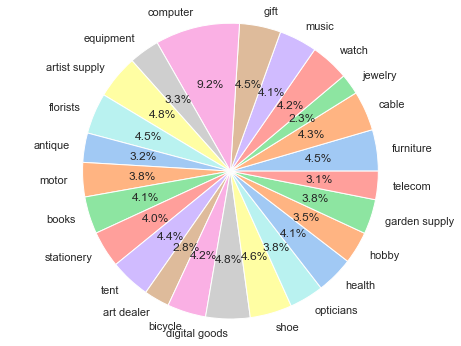

In [3]:
# tag distribution over all merchants
labels = merchant_df['tags'].unique()
sizes = []
for tag in labels:
    sizes.append(len(merchant_df.loc[merchant_df['tags'] == tag]))

plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')
plt.pie(x=sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

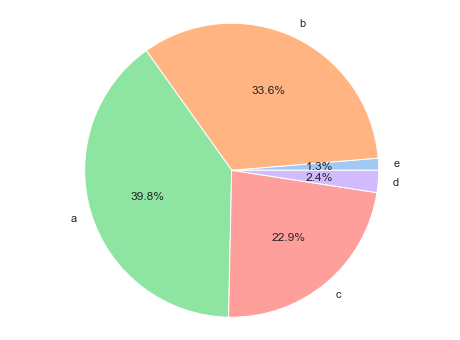

In [4]:
# revenue level distribution over all merchants
labels = merchant_df['revenue_level'].unique()
sizes = []
for tag in labels:
    sizes.append(len(merchant_df.loc[merchant_df['revenue_level'] == tag]))

plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')
plt.pie(x=sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## Transaction Dataset

In [5]:
transaction_sdf = spark.read.parquet('../data/tables/transactions_*/*')\
        .withColumn(
            "order_datetime", 
            F.to_date(F.regexp_extract(F.split(F.input_file_name(), "=")[1], "(.*)/",1), "yyyy-MM-dd")
        )

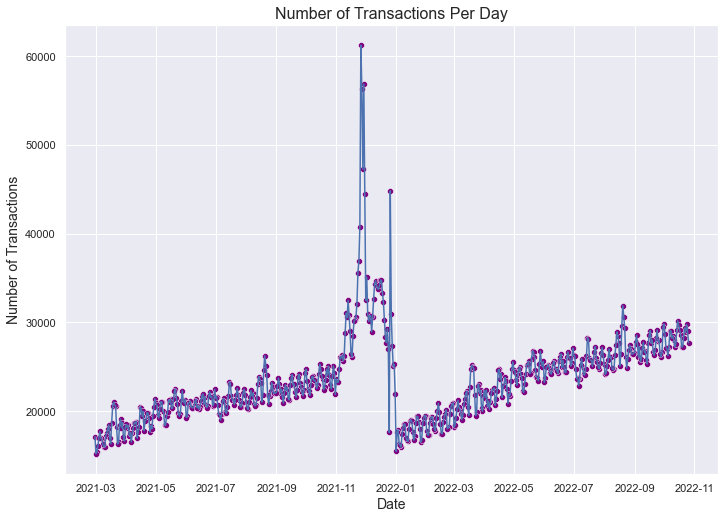

In [6]:
# line plot of number of transactions each day
transaction_count_by_date = transaction_sdf.groupBy('order_datetime').count().toPandas()

sns.lineplot(x='order_datetime', y='count', data=transaction_count_by_date)
sns.scatterplot(x='order_datetime', y='count', data=transaction_count_by_date, color='purple')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.title('Number of Transactions Per Day', fontsize=16)
plt.savefig('../plots/Number of Transactions Each Day.png')
plt.show()

In [7]:
log_sdf = transaction_sdf.withColumn('log(dollar)', F.log(F.col('dollar_value')))
log_cost = log_sdf.select('log(dollar)').toPandas()

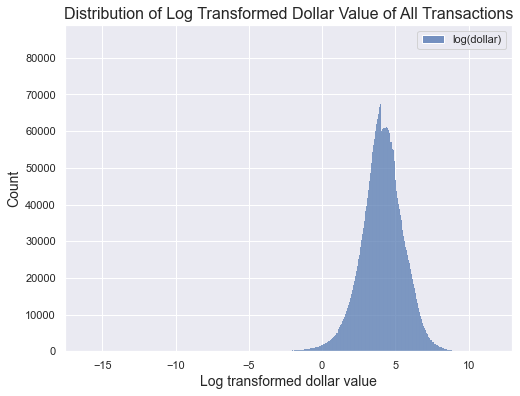

In [8]:
# histogram showing the distribution of dollar value of all transactions
sns.set(rc={'figure.figsize':(8,6)})
fig = sns.histplot(log_cost)
fig.set_title("Distribution of Log Transformed Dollar Value of All Transactions", fontsize=16)
fig.set_xlabel('Log transformed dollar value', fontsize=14)
fig.set_ylabel('Count', fontsize=14)
fig = fig.get_figure()
fig.savefig('../plots/Distribution of Log Transformed Dollar Value of All Transactions.png')

## Consumer Dataset

In [9]:
consumer_df = pd.read_parquet("../data/curated/consumer/")

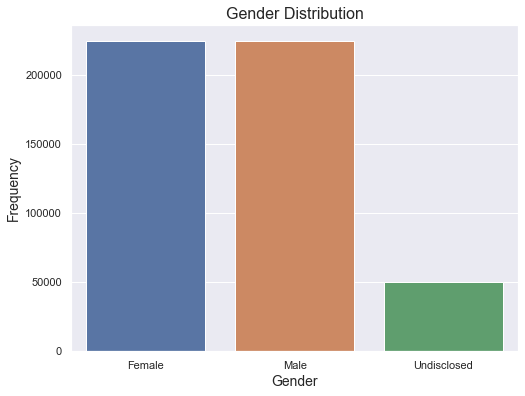

In [10]:
# observe the distribution of gender among consumers
gender_df = consumer_df[['user_id', 'gender']].groupby(['gender']).count()

sns.barplot(data=gender_df, x=gender_df.index, y="user_id")
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Gender Distribution', fontsize=16)
plt.savefig('../plots/gender distribution.png')
plt.show()

In [11]:
# find number of consumers in each state
state_df = consumer_df[['state', 'user_id']].groupby(['state']).count()
state_df

,user_id
state,
ACT,4664
NSW,144188
NT,7764
QLD,72861
SA,54973
TAS,18878
VIC,117525
WA,79146


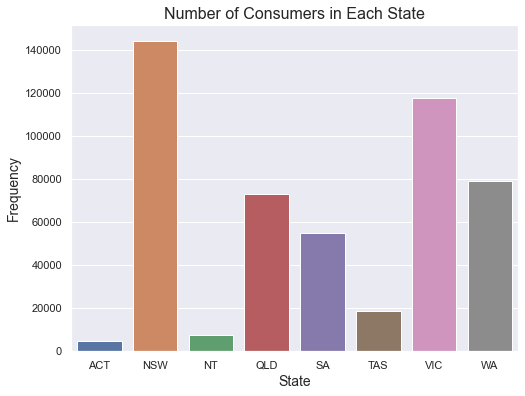

In [12]:
sns.barplot(data=state_df, x=state_df.index, y="user_id")
plt.xlabel('State', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Number of Consumers in Each State', fontsize=16)
plt.savefig('../plots/consumer distribution.png')
plt.show()